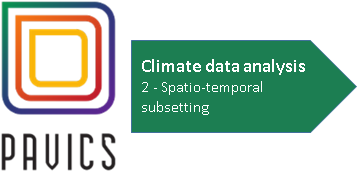

In this second tutorial we will demonstate PAVICS subsetting tools, again accessing Ouranos' cb-oura-1.0 ensemble.  PAVICS subsetting relies on the `clisops` library enabling data extraction by:
* Point location(s) 
* Bounding box 
* Polygon
* Time range

This tutorial uses [clisops](https://clisops.readthedocs.io/en/latest/notebooks/core_subset.html) for subsetting operations, and [geopandas](https://geopandas.org/) to manipulate region geometries.  

We re-use part of the data-access tutorial to select a dataset from cb-oura-1.0 datasets from the PAVICS THREDDS server.
___

*NOTE : To run this series of tutorials in the PAVICS jupyterhub, notebooks should be copied into your 'writable-workspace' directory*

<xarray.Dataset>
Dimensions:  (lat: 700, lon: 1064, time: 55115)
Coordinates:
  * lon      (lon) float32 -141.04314 -140.9598 ... -52.54667 -52.46334
  * lat      (lat) float32 83.28931 83.20598 83.12265 ... 25.12497 25.04164
  * time     (time) object 1950-01-01 00:00:00 ... 2100-12-31 00:00:00
Data variables:
    tasmin   (time, lat, lon) float32 ...
    tasmax   (time, lat, lon) float32 ...
    pr       (time, lat, lon) float32 ...
Attributes:
    Conventions:                CF-1.5
    title:                      Ouranos standard ensemble of bias-adjusted cl...
    history:                    2011-06-01T01:08:07Z CMOR rewrote data to com...
    institution:                Ouranos Consortium on Regional Climatology an...
    source:                     NorESM1-M 2011  atmosphere: CAM-Oslo (CAM4-Os...
    institute_id:               Ouranos
    type:                       GCM
    processing:                 bias_adjusted
    dataset_description:        https://www.ouranos.ca/publication-scientifiq...
    bias_adjustment_method:     1D-Quantile Mapping
    bias_adjustment_reference:  http://doi.org/10.1002/2015JD023890
    project_id:                 CMIP5
    licence_type:               permissive
    terms_of_use:               Terms of use at https://www.ouranos.ca/climat...
    attribution:                Use of this dataset should be acknowledged as...
    frequency:                  day
    modeling_realm:             atmos
    target_dataset:             CANADA : ANUSPLIN interpolated Canada daily 3...
    target_dataset_references:  CANADA : https://doi.org/10.1175/2011BAMS3132...
    driving_institution:        Norwegian Climate Centre
    driving_institute_id:       NCC
    driving_model:              NorESM1-M
    EXTRA_DIMENSION.ts:         3

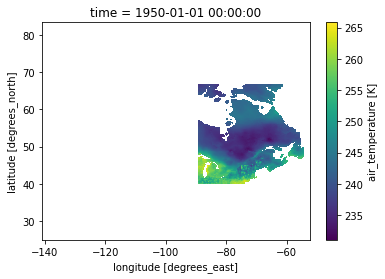

In [1]:
import xarray as xr
from siphon.catalog import TDSCatalog
from IPython.display import display  # Fancy representation of xarray objects

url = "https://pavics.ouranos.ca/twitcher/ows/proxy/thredds/catalog/datasets/simulations/bias_adjusted/cmip5/ouranos/cb-oura-1.0/catalog.xml"

# Create Catalog
cat = TDSCatalog(url)

# DAP link for this demo
ds_url = cat.datasets[0].access_urls["OPENDAP"]

# xarray.Dataset
ds = xr.open_dataset(ds_url)
display(ds)
ds.tasmin.isel(time=0).plot()

___
## Subsetting point location(s)

 The `subset_gridpoint` function returns the grid-cell whose center lies closest to the coordinates (latitude, longitude) given. When multiple coordinates are given, the various grid points are ordered along a new  `site` dimension.
 
 Use cases:
 
 - Compare gridded model output to observations at different weather station locations
 - Extract climate time series for cities or other sites of interest


<xarray.Dataset>
Dimensions:  (site: 3, time: 55115)
Coordinates:
    lon      (site) float32 -75.37909 -84.96204 -65.46282
    lat      (site) float32 46.70744 41.041 55.29043
  * time     (time) object 1950-01-01 00:00:00 ... 2100-12-31 00:00:00
Dimensions without coordinates: site
Data variables:
    tasmin   (time, site) float32 ...
    tasmax   (time, site) float32 ...
    pr       (time, site) float32 ...
Attributes:
    Conventions:                CF-1.5
    title:                      Ouranos standard ensemble of bias-adjusted cl...
    history:                    2011-06-01T01:08:07Z CMOR rewrote data to com...
    institution:                Ouranos Consortium on Regional Climatology an...
    source:                     NorESM1-M 2011  atmosphere: CAM-Oslo (CAM4-Os...
    institute_id:               Ouranos
    type:                       GCM
    processing:                 bias_adjusted
    dataset_description:        https://www.ouranos.ca/publication-scientifiq...
    bias_adjustment_method:     1D-Quantile Mapping
    bias_adjustment_reference:  http://doi.org/10.1002/2015JD023890
    project_id:                 CMIP5
    licence_type:               permissive
    terms_of_use:               Terms of use at https://www.ouranos.ca/climat...
    attribution:                Use of this dataset should be acknowledged as...
    frequency:                  day
    modeling_realm:             atmos
    target_dataset:             CANADA : ANUSPLIN interpolated Canada daily 3...
    target_dataset_references:  CANADA : https://doi.org/10.1175/2011BAMS3132...
    driving_institution:        Norwegian Climate Centre
    driving_institute_id:       NCC
    driving_model:              NorESM1-M
    EXTRA_DIMENSION.ts:         3

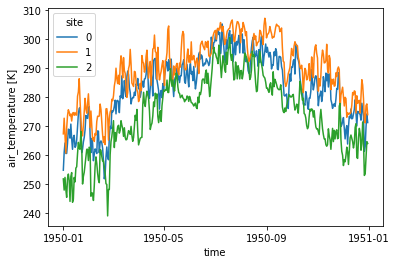

In [2]:
from clisops.core import subset

lon=[-75.4, -85, -65.5]  # Longitude
lat=[46.67, 41, 55.3]  # Latitude

ds_gridpoint = subset.subset_gridpoint(ds, lon=lon, lat=lat)
display(ds_gridpoint)

# Plot first year of tasmax data
ds_gridpoint.tasmax.isel(time=slice(0,365)).plot.line(x='time')

The distance to the closest grid point can sometimes so large that's it's not meaningful anymore. To avoid such cases, a maximum distance can be set using the `tolerance` argument. Also, the actual distance can also be added as a coordinate for manual inspection.

In [3]:
subset.subset_gridpoint(ds, lon=lon, lat=lat, add_distance=True).distance

<xarray.DataArray 'distance' (site: 3)>
array([4458.75328944, 5560.94197182, 2590.95839354])
Coordinates:
    lon       (site) float32 -75.37909 -84.96204 -65.46282
    lat       (site) float32 46.70744 41.041 55.29043
    distance  (site) float64 4.459e+03 5.561e+03 2.591e+03
Dimensions without coordinates: site
Attributes:
    units:    m

___
## Subsetting using a boundary box

The  `subset_bbox` function extracts data within latitude and longitude bounds (min, max). 

Use cases

- Extract a rectangular region around a site or region of interest
- Extract tropical, subtropical or polar latitudes

<xarray.Dataset>
Dimensions:  (lat: 132, lon: 244, time: 55115)
Coordinates:
  * lon      (lon) float32 -80.46222 -80.37889 -80.29556 ... -60.29636 -60.21303
  * lat      (lat) float32 54.95711 54.87378 54.79045 ... 44.12421 44.04088
  * time     (time) object 1950-01-01 00:00:00 ... 2100-12-31 00:00:00
Data variables:
    tasmin   (time, lat, lon) float32 ...
    tasmax   (time, lat, lon) float32 ...
    pr       (time, lat, lon) float32 ...
Attributes:
    Conventions:                CF-1.5
    title:                      Ouranos standard ensemble of bias-adjusted cl...
    history:                    2011-06-01T01:08:07Z CMOR rewrote data to com...
    institution:                Ouranos Consortium on Regional Climatology an...
    source:                     NorESM1-M 2011  atmosphere: CAM-Oslo (CAM4-Os...
    institute_id:               Ouranos
    type:                       GCM
    processing:                 bias_adjusted
    dataset_description:        https://www.ouranos.ca/publication-scientifiq...
    bias_adjustment_method:     1D-Quantile Mapping
    bias_adjustment_reference:  http://doi.org/10.1002/2015JD023890
    project_id:                 CMIP5
    licence_type:               permissive
    terms_of_use:               Terms of use at https://www.ouranos.ca/climat...
    attribution:                Use of this dataset should be acknowledged as...
    frequency:                  day
    modeling_realm:             atmos
    target_dataset:             CANADA : ANUSPLIN interpolated Canada daily 3...
    target_dataset_references:  CANADA : https://doi.org/10.1175/2011BAMS3132...
    driving_institution:        Norwegian Climate Centre
    driving_institute_id:       NCC
    driving_model:              NorESM1-M
    EXTRA_DIMENSION.ts:         3

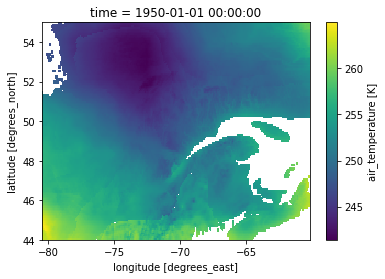

In [4]:
# Specify the longitude and latitude boundaries
lon_bnds = [-80.5, -60.2]
lat_bnds = [44, 55]

ds1 = subset.subset_bbox(ds, lon_bnds=lon_bnds, lat_bnds=lat_bnds)
display(ds1)

#Plot a map of first timestep
ds1.tasmax.isel(time=0).plot()

___
## Subsetting using a polygon

The `subset_shape` function can extract data within an arbitrary shape defined by one or multiple polygons. It crops the original grid to the polygon then masks everything outside it. 

Use cases:

- Analyze climate variables within a country, state or watershed
- Study climate patterns over the Arctic ocean

The example below demonstate subsetting using a geojson layer for southern Quebec administative regions.

,isSubreg,AreaKm2,Region,Stride,RegType,geometry
0,1,64619.543075,Abitibi-Témiscamingue,1,admin,"MULTIPOLYGON (((-75.52055 49.00002, -75.52064 ..."
1,1,19429.113878,Capitale-Nationale,1,admin,"MULTIPOLYGON (((-70.78151 46.97156, -70.80159 ..."
2,1,7035.163146,Centre-du-Québec,1,admin,"MULTIPOLYGON (((-72.03655 46.55848, -72.03607 ..."
3,1,15267.682927,Chaudière-Appalaches,1,admin,"MULTIPOLYGON (((-70.64336 47.02725, -70.64995 ..."
4,1,10502.393578,Estrie,1,admin,"MULTIPOLYGON (((-70.41361 45.79600, -70.41368 ..."


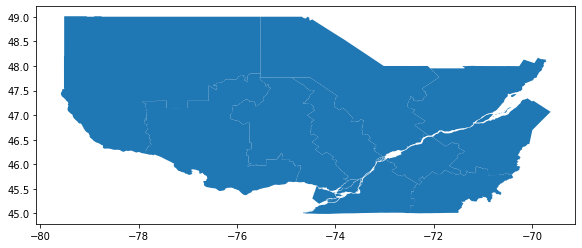

In [8]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Explore the polygon layer
regions = gpd.GeoDataFrame.from_file('test_regions.geojson')

# Display the first few columns
display(regions.head())

# Plot the layer to see what it looks like
display(regions.plot(figsize=(10,4)))


In [10]:
# Subset over all regions 
ds_poly = subset.subset_shape(ds, shape='test_regions.geojson') #use path to layer

ds_poly.tasmin.isel(time=0).plot()

RuntimeError: NetCDF: DAP server error

#### **a. Extracting data `subset_shape`**
Use`subset_shape` by providing the polygon layer filepath as input 

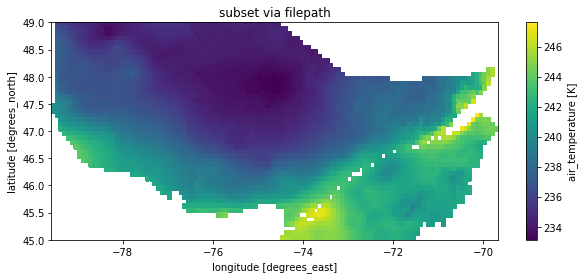

In [8]:
ds_poly = subset.subset_shape(ds, shape='test_regions.geojson') #use path to layer
plt.figure(figsize=(10, 4)) 
ds_poly.tasmin.isel(time=0).plot()
plt.title('subset via filepath')
display()

___
## Subsetting time

The `subset_time` fonction is used to extract a time span. It uses `start_date` and/or `end_date` arguments, which can be given as year, year-month or year-month-day strings. If the start or end date is not given, it defaults to the start or end date of the dataset respectively.

Use cases

- Align datasets to a common starting date
- Compute a climatology over 30-years



In [13]:
# Align data to a starting year
ds_sub = subset.subset_time(ds, start_date='1981')
print(f"Subset time using start_date only\nstart: {ds_sub.time.min().values};\tend: {ds_sub.time.max().values}\n")

# Select a temporal slice
ds_sub = subset.subset_time(ds, start_date='1981-08-05', end_date='2084-06-15')
print(f"Subset time using both start_date & end_date\nstart: {ds_sub.time.min().values};\tend: {ds_sub.time.max().values}")

Subset time using start_date only
start: 1981-01-01 00:00:00;	end: 2100-12-31 00:00:00

Subset time using both start_date & end_date
start: 1981-08-05 00:00:00;	end: 2084-06-15 00:00:00


___
### **Advanced subsetting examples**
#### **a. Extracting data using a `geopandas.GeoDataFrame`**
When using `subset_shape` it can sometimes be useful to manipulate the polygon layer before subsetting. For example subsetting using a polygon layer with non geographic coordinates (latitude/longitude) will result in an error. By loading the layer first as a geodataframe we can perform a reprojection on the fly using`to_crs()`

There was a problemn... the polygon layer projection is NAD83 / Canada Atlas Lambert
try projecting to WGS 84 ... 


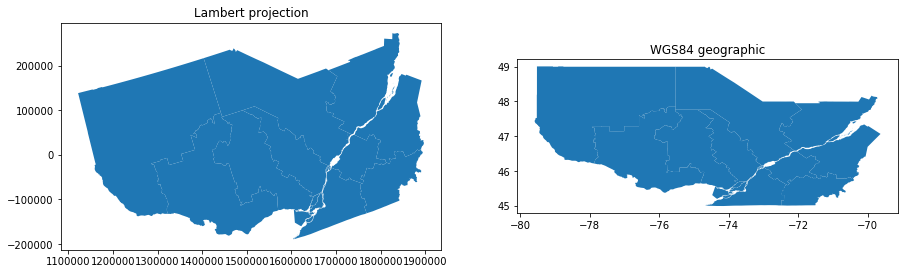

In [11]:
# Demo using lambert projected polygon layer
regions_lcc= gpd.GeoDataFrame.from_file('test_regions_lambert.geojson')
plt.figure(figsize=(15, 6))
ax1 = plt.subplot(1,2,1)
regions_lcc.plot(ax=ax1)
plt.title('Lambert projection')
ax2 = plt.subplot(1,2,2)
regions_lcc.to_crs(epsg=4326).plot(ax=ax2)
plt.title('WGS84 geographic')
display()
try :
    ds_poly1 = subset.subset_shape(ds, regions_lcc)
except:
    print(f'There was a problemn... the polygon layer projection is {regions_lcc.crs.name}\ntry projecting to WGS 84 ... ')

   

success


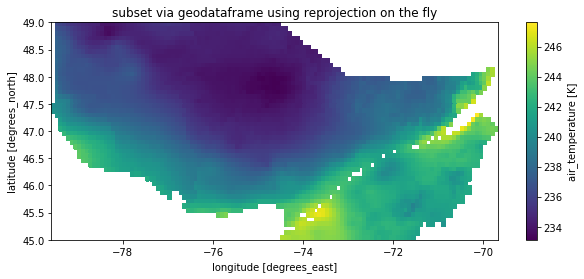

In [12]:
ds_poly1 =  subset.subset_shape(ds, regions_lcc.to_crs(epsg=4326))
ds_poly1.tasmin.isel(time=0).plot(figsize=(10,4))
plt.title('subset via geodataframe using reprojection on the fly')
display()
print('success')

We may also wish to subset the climate only data using a selection of available polygons. For example use only the Montérégie and Outaouais subregions

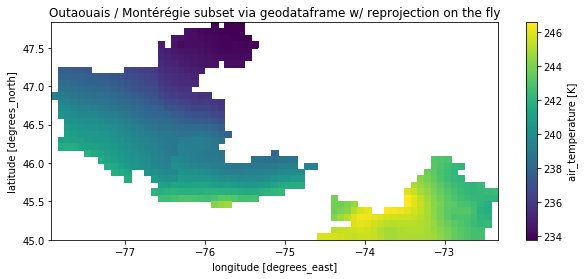

In [13]:
subreg = regions_lcc.loc[(regions_lcc['Region'] == 'Outaouais') | (regions_lcc['Region'] == 'Montérégie')]
ds_poly1 =  subset.subset_shape(ds, subreg.to_crs(epsg=4326))
    
ds_poly1.tasmin.isel(time=0).plot(figsize=(10, 4))
plt.title('Outaouais / Montérégie subset via geodataframe w/ reprojection on the fly')
display()

#### **b. Creating a mask**
Mask creation allows subsetting with the entire set of polygons while still allowing manipulation and access to subregions in the resulting dataset 

Text(0.5, 1.0, 'Mask of regions')

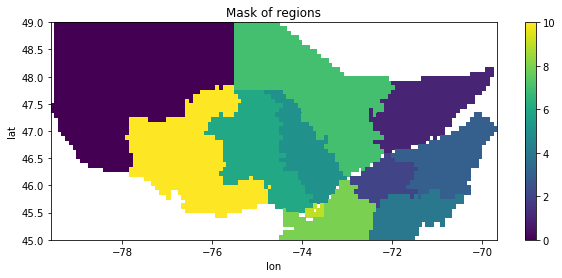

In [14]:
mask = subset.create_mask_vectorize(x_dim = ds_poly.lon, y_dim=ds_poly.lat, poly=regions).transpose()
mask.plot(figsize=(10,4))
plt.title('Mask of regions')

Assign a `region_id` and `region_name` coordinates to the data using the mask
* coordinates can be used to select or summarize data by region

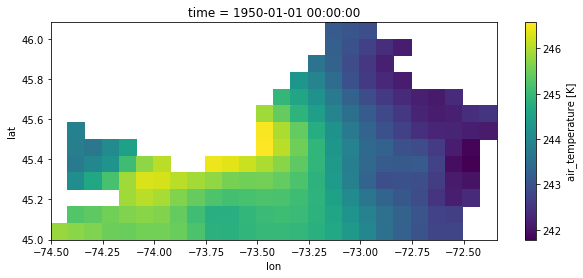

In [15]:
ds_poly = ds_poly.assign_coords(region_id=mask)

# create region_name coordinates
name_array = xr.full_like(ds_poly.region_id, '', dtype=object)
name_field = 'Region'
for i, name in enumerate(regions[name_field]):
    
    name_array = xr.where(ds_poly['region_id'] == i, name, name_array)
    ds_poly = ds_poly.assign_coords(region_name=name_array)

    
# Plot only a single region by selecting w/ region_name coordinate
ds_poly.where(ds_poly.region_name=='Montérégie', drop=True).tasmin.isel(time=0).plot(figsize=(10,4))

#### **c. Subsetting Curvilinear Grids** 
Climate model data is often produced using rotated-pole coordinates resulting in irregular or curvlinear lat/lon grids.  Considerable effort has been made in the subsetting tools to seamlessly handle this type of data 

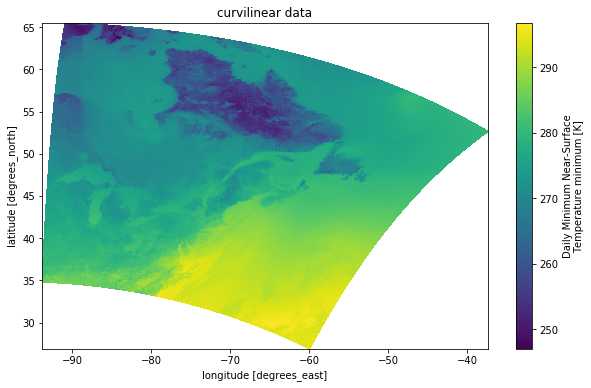

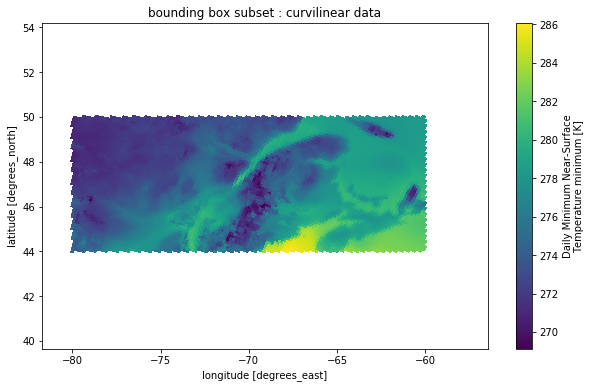

In [16]:
testurl = 'https://pavics.ouranos.ca/twitcher/ows/proxy/thredds/dodsC/birdhouse/ouranos/climex/QC11d3_CCCma-CanESM2_rcp85/day/rcp85-r1-r1i1p1/tasmin/tasmin_kda_209604_se.nc'
ds = xr.open_dataset(testurl, chunks=dict(time=10))
ds.tasmin.isel(time=0).plot(x='lon',y='lat', figsize=(10,6))
plt.title('curvilinear data')
ds_sub = subset.subset_bbox(ds, lat_bnds=[44, 50], lon_bnds=[-80, -60])
ds_sub.tasmin.isel(time=0).plot(x='lon',y='lat', figsize=(10,6))
plt.title('bounding box subset : curvilinear data')
display()